In [2]:
import meep as mp
from sources.mpb_configurator import *
from sources.photonic_crystal_maker import *

 # Example usage
lattice = Lattice("TX", (1, 1, 'no-size'))
material = Material(epsilon=12)
geometry = [Geometry(mp.Cylinder, {"center": mp.Vector3(0, 0), "radius": 0.2, "height": mp.inf, "material": material})]
pc = PhotonicCrystal(geometry, lattice, material)


# Define the MPB configuration
config = MPBConfiguration(simulation_type="te", resolution=32, num_bands=8, geometry_lattice=lattice, geometry=geometry)
k_points = [mp.Vector3(0, 0, 0), mp.Vector3(0.5, 0, 0), mp.Vector3(0.5, 0.5, 0), mp.Vector3(0, 0, 0)]
config.k_points = k_points


# Generate the Scheme configuration
scheme = config.generate_scheme_config("mpb_config.ctl")
print(scheme)


Scheme configuration written to mpb_config.ctl
(set! num-bands 8)
(set! resolution 32)

(set! k-points (list (vector3 0.0 0.0 0.0) (vector3 0.5 0.0 0.0) (vector3 0.5 0.5 0.0) (vector3 0.0 0.0 0.0)))
(set! k-points (interpolate 4 k-points))
(set! geometry (list
    (make cylinder (center (vector3 0.0 0.0 0.0))(radius 0.2)(height 1e+20)(material (make dielectric (epsilon 12))))
))
(set! geometry-lattice (make lattice (size 1 1 no-size)  (basis1  (vector3 1.0 0.0 0.0)) (basis2  (vector3 0.5000000000000001 0.8660254037844388 0.0)) ))
(run-te)



In [51]:
import subprocess
import os
simulation_name = "tutorial"
os.makedirs(simulation_name, exist_ok=True)
os.chdir(simulation_name)

# Write the Scheme configuration to a file
scheme = config.generate_scheme_config("tutorial.ctl")
print (scheme)



Scheme configuration written to tutorial.ctl
(set! num-bands 8)
(set! resolution 32)

(set! k-points (list (vector3 0.0 0.0 0.0) (vector3 0.5 0.0 0.0) (vector3 0.5 0.5 0.0) (vector3 0.0 0.0 0.0)))
(set! k-points (interpolate 4 k-points))
(set! geometry (list
    (make cylinder (center (vector3 0.0 0.0 0.0))(radius 0.2)(height 1e+20)(material (make dielectric (epsilon 12))))
))
(set! geometry-lattice (make lattice (size 1 1 no-size)  (basis1  (vector3 1.0 0.0 0.0)) (basis2  (vector3 0.5000000000000001 0.8660254037844388 0.0)) ))
(run-te)



In [52]:

# Run the simulation
scheme_insturctions = simulation_name + ".ctl"
output_file = simulation_name + ".out"
error_file  = simulation_name + ".err"
command = ["mpb", scheme_insturctions]
result = subprocess.run(command, capture_output=True, text=True)

# Save the output and error to files
with open(output_file, "w") as f_out:
    f_out.write(result.stdout)
with open(error_file, "w") as f_err:
    f_err.write(result.stderr)


init-params: initializing eigensolver data
Computing 8 bands with 1.000000e-07 tolerance.
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.2, height 1e+20, axis (0, 0, 1)
          epsilon = 12, mu = 1
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
16 k-points:
     (0,0,0)
     (0.1,0,0)
     (0.2,0,0)
     (0.3,0,0)
     (0.4,0,0)
     (0.5,0,0)
     (0.5,0.1,0)
     (0.5,0.2,0)
     (0.5,0.3,0)
     (0.5,0.4,0)
     (0.5,0.5,0)
     (0.4,0.4,0)
     (0.3,0.3,0)
     (0.2,0.2,0)
     (0.1,0.1,0)
     (0,0,0)
Solving for band polarization: te.
Initializing fields to random n

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


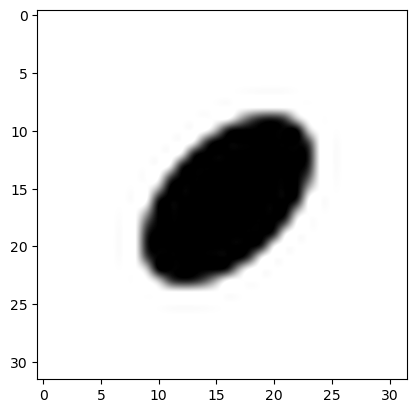

In [27]:
import h5py

# Load the results
filename = "mpb_config-epsilon.h5" 
with h5py.File(filename, 'r') as f:
    epsilon = f['data'][...]

print(epsilon)

import matplotlib.pyplot as plt
import numpy as np

# Plot the results
plt.imshow(epsilon[:, :], interpolation='spline36', cmap='binary')



In [19]:
import os 
import subprocess
import sources.mpb_configurator as mpb_configurator 

class SimulationRunner: 
    def __init__(self, simulation_name, config: mpb_configurator.MPBConfiguration = None, description=None):    
        self.simulation_name = simulation_name
        self.config = config
        self.output_file = simulation_name + ".out"
        self.error_file = simulation_name + ".err"
        self.scheme_insturctions = simulation_name + ".ctl"
        self.description = description  
        if description is not None:
            desc_path = simulation_name + ".txt"
            with open(desc_path, "w") as f:
                f.write(description)
    
    def set_config(self, config):   
        self.config = config
    

    def run(self, print_config=False):
        if self.config is None:
            raise ValueError("No configuration provided for the simulation, use run_from_scheme_script instead")
        simulation_path = self.simulation_name
        print(f"Running simulation {self.simulation_name}")

        # Create the simulation directory if it does not exist
        os.makedirs(simulation_path, exist_ok=True)

        # Write the Scheme configuration to a file in the simulation directory
        scheme_file_path = os.path.join(simulation_path, self.scheme_insturctions)
        scheme = self.config.generate_scheme_config(scheme_file_path)
        if print_config:
            print(scheme)
        with open(scheme_file_path, "w") as f:
            f.write(scheme)

        # Run the simulation inside the simulation directory
        command = ["mpb", self.scheme_insturctions]
        result = subprocess.run(command, capture_output=True, text=True, cwd=simulation_path)

        # Save the output and error to files in the simulation directory
        output_file_path = os.path.join(simulation_path, self.output_file)
        error_file_path = os.path.join(simulation_path, self.error_file)
        with open(output_file_path, "w") as f_out:
            f_out.write(result.stdout)
        with open(error_file_path, "w") as f_err:
            f_err.write(result.stderr)

        print("Simulation completed")

    def run_from_scheme_script(self, scheme_script):    
        simulation_path = self.simulation_name
        print(f"Running simulation {self.simulation_name}")

        # Create the simulation directory if it does not exist
        os.makedirs(simulation_path, exist_ok=True)

        # Run the simulation inside the simulation directory
        command = ["mpb", scheme_script]
        result = subprocess.run(command, capture_output=True, text=True, cwd=simulation_path)

        # Save the output and error to files in the simulation directory
        output_file_path = os.path.join(simulation_path, self.output_file)
        error_file_path = os.path.join(simulation_path, self.error_file)
        with open(output_file_path, "w") as f_out:
            f_out.write(result.stdout)
        with open(error_file_path, "w") as f_err:
            f_err.write(result.stderr)

        print("Simulation completed")


    def extract_frequencies_data(self, remove_line_prefixes=True):
        """
        Assemble the frequency data from the output file and optionally remove line prefixes.
        """
        # Define the prefixes to remove from each line.
        prefixes = ["tmfreqs:", "tefreqs:", "gaps:"]

        def strip_prefix(line, prefixes):
            for prefix in prefixes:
                if line.startswith(prefix):
                    return line[len(prefix):].lstrip(" ,")
            return line

        simulation_path = self.simulation_name
        output_filename = os.path.join(simulation_path, f"{self.simulation_name}.out")
        print(f"Extracting data from {output_filename}")
        
        with open(output_filename, "r") as f:
            lines = f.readlines()

        tm_lines = [strip_prefix(line, prefixes) if remove_line_prefixes else line 
                    for line in lines if "tmfreqs:" in line]
        te_lines = [strip_prefix(line, prefixes) if remove_line_prefixes else line 
                    for line in lines if "tefreqs:" in line]
        gaps_lines = [strip_prefix(line, prefixes) if remove_line_prefixes else line 
                      for line in lines if "gaps:" in line]

        tm_file = os.path.join(simulation_path, f"{self.simulation_name}.tm.dat")
        with open(tm_file, "w") as f_tm:
            f_tm.writelines(tm_lines)
        print(f"Extracted {len(tm_lines)} lines of data for the TM mode")

        te_file = os.path.join(simulation_path, f"{self.simulation_name}.te.dat")
        with open(te_file, "w") as f_te:
            f_te.writelines(te_lines)
        print(f"Extracted {len(te_lines)} lines of data for the TE mode")

        gaps_file = os.path.join(simulation_path, f"{self.simulation_name}.gaps.dat")
        with open(gaps_file, "w") as f_gaps:
            f_gaps.writelines(gaps_lines)
        print(f"Extracted {len(gaps_lines)} lines of data for the gaps")
        

# Example usage remains the same
lattice = Lattice("TX", (1, 1, 'no-size'))
material = Material(epsilon=12)
geometry = [Geometry(mp.Cylinder, {"center": mp.Vector3(0, 0, 0), "radius": 0.2, "height": mp.inf, "material": material})]
pc = PhotonicCrystal(geometry, lattice, material)

# Define the MPB configuration
config = MPBConfiguration(simulation_type="te", resolution=32, num_bands=8, geometry_lattice=lattice, geometry=geometry)
k_points = [mp.Vector3(0, 0, 0), mp.Vector3(0.5, 0, 0), mp.Vector3(0.5, 0.5, 0), mp.Vector3(0, 0, 0)]
config.k_points = k_points

runner = SimulationRunner("test", config)
runner.run(print_config=True)
runner.extract_frequencies_data()


Running simulation test
Scheme configuration written to test/test.ctl
(set! num-bands 8)
(set! resolution 32)

(set! k-points (list (vector3 0.0 0.0 0.0) (vector3 0.5 0.0 0.0) (vector3 0.5 0.5 0.0) (vector3 0.0 0.0 0.0)))
(set! k-points (interpolate 4 k-points))
(set! geometry (list
    (make cylinder (center (vector3 0.0 0.0 0.0))(radius 0.2)(height 1e+20)(material (make dielectric (epsilon 12))))
))
(set! geometry-lattice (make lattice (size 1 1 no-size)  (basis1  (vector3 1.0 0.0 0.0)) (basis2  (vector3 0.5000000000000001 0.8660254037844388 0.0)) ))
(run-te)

Simulation completed
Extracting data from test/test.out
Extracted 0 lines of data for the TM mode
Extracted 17 lines of data for the TE mode
Extracted 0 lines of data for the gaps


real part range: 1 .. 12


real part range: 1 .. 12


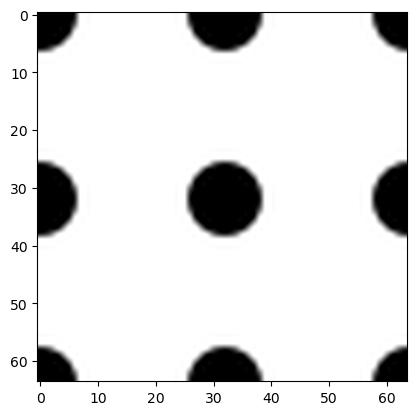

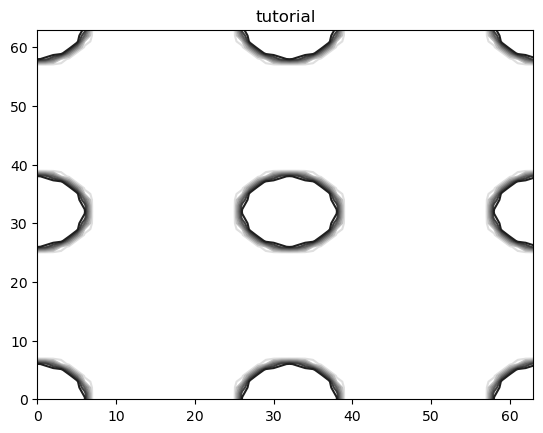

,k index,k1,k2,k3,kmag/2pi,te band 1,te band 2,te band 3,te band 4,te band 5,te band 6,te band 7,te band 8
0,1,0.0,0.0,0,0.000000,0.000000,0.552709,0.773227,0.773230,0.922997,1.000170,1.000170,1.09282
1,2,0.1,0.0,0,0.100000,0.089733,0.551138,0.761600,0.774682,0.907199,1.001880,1.003570,1.11423
2,3,0.2,0.0,0,0.200000,0.178692,0.544896,0.728534,0.778528,0.880244,1.006990,1.016960,1.10027
3,4,0.3,0.0,0,0.300000,0.265798,0.528176,0.685449,0.783377,0.860714,1.015150,1.038430,1.09664
4,5,0.4,0.0,0,0.400000,0.348956,0.490738,0.652797,0.787382,0.849999,1.024430,1.064410,1.09121
5,6,0.5,0.0,0,0.500000,0.412791,0.441588,0.641998,0.788933,0.846588,1.029160,1.086070,1.08787
6,7,0.5,0.1,0,0.509902,0.423741,0.445781,0.638230,0.793147,0.842943,0.986523,1.050180,1.10383
7,8,0.5,0.2,0,0.538516,0.454781,0.457434,0.627898,0.805254,0.826101,0.927945,1.004560,1.10879
8,9,0.5,0.3,0,0.583095,0.473767,0.501279,0.613580,0.781467,0.824181,0.894949,0.959051,1.11070
9,10,0.5,0.4,0,0.640312,0.489649,0.556045,0.599570,0.719611,0.849247,0.884337,0.917168,1.11162


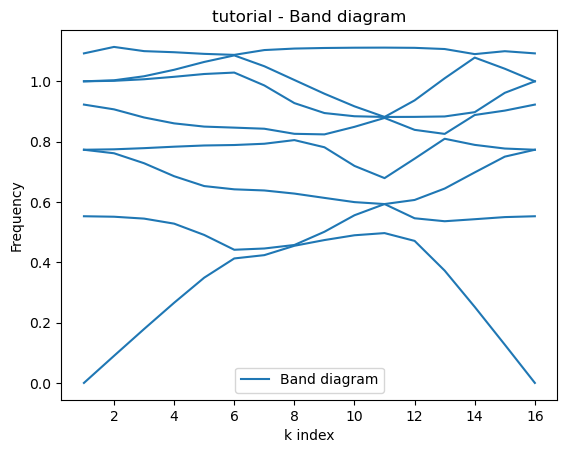

In [35]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from meep import mpb 
import meep as mp
import os 
import pandas as pd
import sqlite3


class SimulationDataExtractor:
    def __init__(self, simulation_name: str, directory: str | None = None):
        """
        Initialize the SimulationDataExtractor object with the simulation name and description.
        """
        self.simulation_name = simulation_name
        self.directory = directory if directory is not None else simulation_name

        self.epsilon = None
        self.lattice = None
        self.description = self._load_description()
        self.bands_df = {}




        
        

    def _load_description(self) -> str: 
        """
        Load the description of the simulation from the description file.
        """
        description_file = os.path.join(self.directory, f"{self.simulation_name}.txt")
        if not os.path.exists(description_file):
            return ""
        with open(description_file, "r") as f:
            description = f.read()
        return description
    
    def load_epsilon(self) -> None:
        """
        Load epsilon and lattice vectors from an HDF5 file.
        """
        directory = os.path.join(os.getcwd(), self.simulation_name)
        filepath = os.path.join(directory, f"{self.simulation_name}-epsilon.h5")
        with h5py.File(filepath, 'r') as f:
            self.epsilon = f['data'][...]
            self.lattice = f['lattice vectors'][...]

    def _apply_title(self, default_title: str, title: str | None) -> None:
        if title is False:
            return
        elif title is not None:
            plt.title(title)
        else:
            plt.title(default_title)

    def convert_epsilon(self, periods: int | tuple = 1, use_2d: bool = True) -> np.ndarray:
        """
        Convert the epsilons using MPB routines. In 2d mode, the slice taken is the
        middle slice along the third axis.
        """
        if self.lattice is None:
            raise ValueError("Lattice is not defined. Call load_epsilon() first.")
        if self.epsilon is None:
            raise ValueError("Epsilon is not defined. Call load_epsilon() first.")
        
        md = mpb.MPBData(rectify=True, periods=periods, lattice=self.lattice)
        eps = self.epsilon
        if use_2d and self.epsilon.ndim == 3:
            mid_index = self.epsilon.shape[2] // 2
            eps = self.epsilon[:, :, mid_index]
        epsilon_converted = md.convert(eps)
        return epsilon_converted

    def plot_epsilon_2d(self, periods: int | tuple, title: str | bool | None = None, converted: bool = True) -> None:
        """
        Plot epsilon data for a 2D simulation. If converted is True, plot the MPB-converted epsilon;
        otherwise, plot the raw epsilon data.
        """
        if self.epsilon is None:
            raise ValueError("Epsilon is not loaded.")
        
        if converted:
            eps = self.convert_epsilon(periods, use_2d=True)
        else:
            eps = self.epsilon
            if eps.ndim == 3:
                mid_index = eps.shape[2] // 2
                eps = eps[:, :, mid_index]
        plt.imshow(eps, interpolation='spline36', cmap='binary')
        self._apply_title(self.simulation_name, title)

    def plot_epsilon_contour(self, periods: int | tuple, title: str | bool | None = None) -> None:
        """
        Plot a contour of the MPB-converted epsilon data for a 2D simulation.
        """
        epsilon_converted = self.convert_epsilon(periods, use_2d=True)
        plt.contour(epsilon_converted, cmap='binary')
        self._apply_title(self.simulation_name, title)

    def _plot_unimplemented_3d(self, title: str | None = None) -> None:
        """
        Placeholder for 3D plotting.
        """
        print("3D epsilon plotting: not implemented yet")   

    def plot_epsilon(self, periods: int | tuple, title: str | bool | None = None, converted: bool = True) -> None:
        """
        Plot epsilon data in either 2D or 3D (using the appropriate method).
        """
        if self.epsilon is None:
            raise ValueError("Epsilon is not loaded.")
        if self.epsilon.ndim == 2 or (self.epsilon.ndim == 3 and converted is not False):
            self.plot_epsilon_2d(periods, title, converted)
        elif self.epsilon.ndim == 3:
            self._plot_unimplemented_3d(title)
        else:
            raise ValueError("Invalid epsilon dimensions.")
        
    def load_frequency_data(self, mode: str = "te") -> pd.DataFrame:
        """
        Load the frequency data from the output file and build a database.
        The file is expected to be a CSV with the following columns:
            k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3,
            te band 4, te band 5, te band 6, te band 7, te band 8

        This method reads the frequencies file from disk, creates a SQLite
        database (in the simulation folder) with a table named 'frequencies', and
        returns the data as a pandas DataFrame.
        """

        # Build file paths for the CSV and the SQLite database
        directory = os.path.join(os.getcwd(), self.simulation_name)
        filepath = os.path.join(directory, f"{self.simulation_name}.{mode}.dat")
        db_path = os.path.join(directory, f"{self.simulation_name}_frequencies.db")
        
        # Read the CSV file (assuming it has a header row as specified)
        df = pd.read_csv(filepath, skipinitialspace=True)
        
        # Create (or replace) the SQLite database with the frequency data
        conn = sqlite3.connect(db_path)
        df.to_sql("frequencies", conn, if_exists="replace", index=False)
        conn.close()

        self.bands_df[mode] = df
        
        return df
    
    def plot_band_diagram(self, mode: str = "te", title: str | None = None, colors: list[str] | str | None = None) -> None: 
        """
        Plot the band diagram for the given mode using the same color for all bands.
        Since they all represent the same kind of modes, only one color is applied for all bands.
        """
        if mode not in self.bands_df:
            self.load_frequency_data(mode)
        df = self.bands_df[mode]
        bands = df.columns[5:]
        
        # Determine the single color to use for all lines.
        if colors is None:
            plot_color = "C0"
        elif isinstance(colors, list):
            plot_color = colors[0] if colors else "C0"
        elif isinstance(colors, str):
            plot_color = colors

        # Plot each band and assign the label only to the first line.
        first_line = True
        for col in bands:
            if first_line:
                plt.plot(df["k index"], df[col], label=f"Band diagram", color=plot_color)
                first_line = False
            else:
                plt.plot(df["k index"], df[col], color=plot_color)
                
        plt.xlabel("k index")
        plt.ylabel("Frequency")
        self._apply_title(f"{self.simulation_name} - Band diagram", title)
        plt.legend()

    






# Example usage
simulation = SimulationDataExtractor("tutorial")
simulation.load_epsilon()

# Plot converted epsilon (default) without title
simulation.plot_epsilon(2, title=False)

plt.figure()
# Plot contour of the converted epsilon
simulation.plot_epsilon_contour(2, title=None)
df = simulation.load_frequency_data()
plt.show()
display(df)

plt.figure()
simulation.plot_band_diagram("te")
plt.show()


Running simulation tutorial
Simulation completed
Extracting data from tutorial/tutorial.out
Extracted 17 lines of data for the TM mode
Extracted 17 lines of data for the TE mode
Extracted 0 lines of data for the gaps
real part range: 1 .. 12


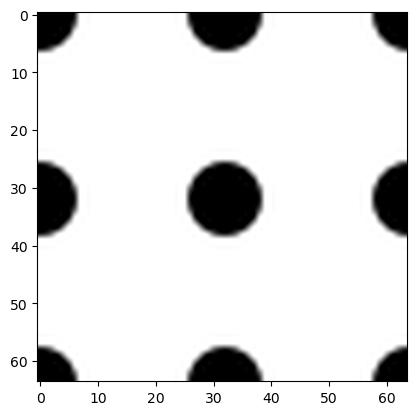

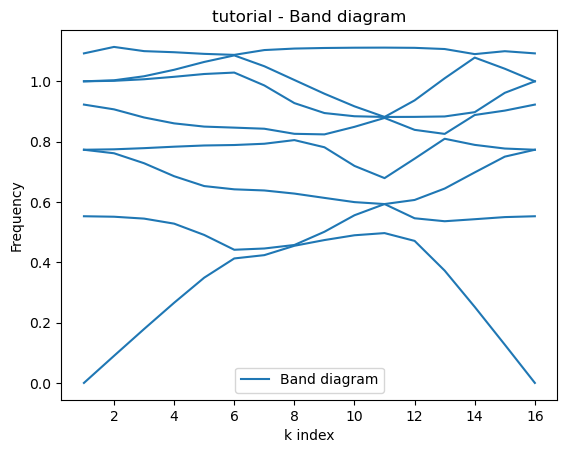

In [36]:
runner  = SimulationRunner("tutorial")
current_directory = os.getcwd()

runner.run_from_scheme_script(os.path.join(current_directory, "tutorial.ctl"))
runner.extract_frequencies_data()

simulation = SimulationDataExtractor("tutorial")
simulation.load_epsilon()
plt.figure()
simulation.plot_epsilon(2, title=False)
plt.show()

plt.figure()
simulation.plot_band_diagram("te")

